### Reimplementation of the Karpathy's Micrograd

In [1]:
import math

# Class representing a value in arithmetic operations
class Value:
    def __init__(self, value, children=(), operation="", label=""):
        # Value of the variable in the formula (if a leaf its set by the user, or else calculated during forward pass)
        self.value = value
        # Gradient of the value, initialized to 0 as the contribution to the final function is computed during backpropagation
        # note: if we would consider the same variable multiple times in the formula, we cannot just set the gradient, as it would be recomputed for each time the variable is present, because of this, we sum each obtained gradient
        self.grad = 0
        # Default value for leaves is an empty function, but when put between operations, the function gets replaced
        self._backward = lambda: None
        # Values is a given formula that contributes to the current value (during forward pass)
        self._children = set(children)
        # The kind of operation that was used to compute the value (addition, multiplication), purely needed for visualization purpose in the graph
        self._operation = operation
        # Label for the value, also this is purely for visualization purpose in the graph
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')

        # In the sum, the gradient of each variable is the same as the gradient of the output, so we just pass it through
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')

        # In the product, the gradient of each variable is the other variable's value times the output's gradient
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        out = Value(self.value**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.value ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.value
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.value * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.value
        # Forward pass for tanh function
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        # Backward pass for tanh function (just look online for the formula)
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    # This function computes the backward pass for the whole graph
    def backward(self):
        # The topological sort is created by traversing the graph in reverse order, for each node, we ensure that we visit all its children before visiting the node itself
        # This ensures that we compute the gradients in the correct order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._children:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # Initialize the gradient of the output node to 1, as we want to compute the gradient of the output with respect to itself
        self.grad = 1.0
        # Compute the whole gradient graph following the topological order
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"value={self.value} grad={self.grad}"

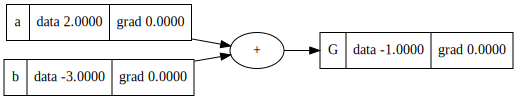

In [2]:
# Copy-pasted code to visualize the whole graph
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.value, n.grad), shape='record')
    if n._operation:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._operation, label = n._operation)
      # and connect this node to it
      dot.edge(uid + n._operation, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

a = Value(2, label="a")
b = Value(-3, label="b")
c = Value(10, label="c")
G = a+b
G.label = "G"

draw_dot(G)

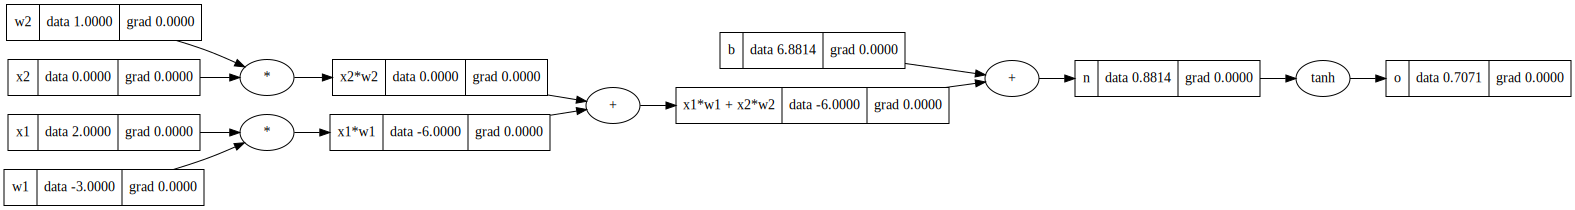

In [3]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

draw_dot(o)

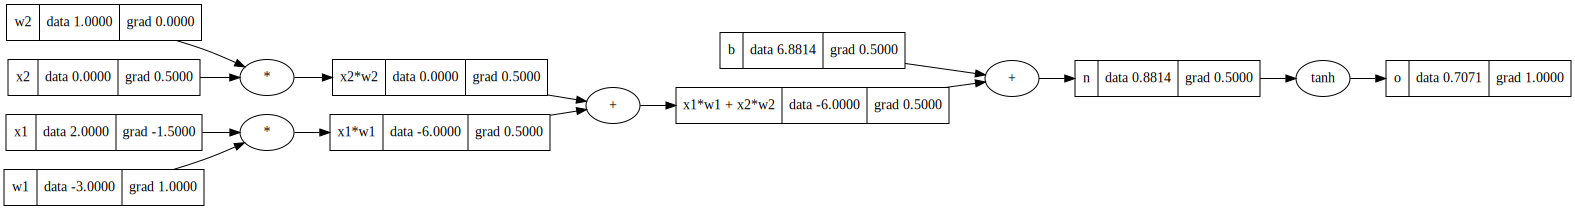

In [4]:
o.backward()
draw_dot(o)

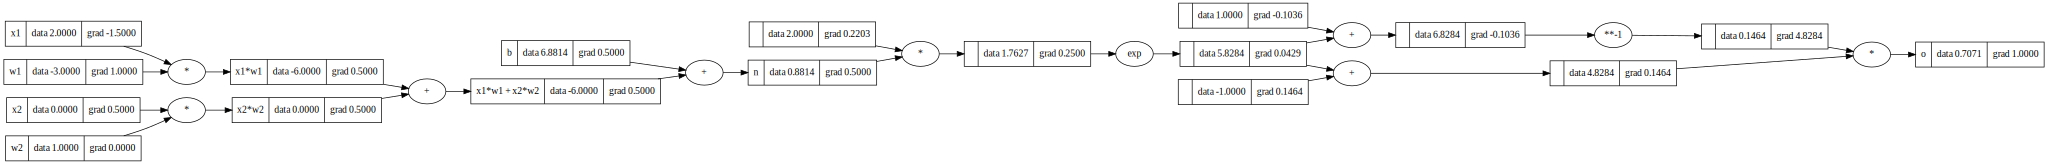

In [5]:
# Previous example, but replacing the tanh activation with a custom activation function

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

In [6]:
# Same previous example, but in PyTorch
import torch
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [7]:
import random

# Example of an MLP implementation

class Neuron:

  def __init__(self, nin):
    # Initialize weights and bias with random values
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # Calculate the activation value as w * x + b, then apply a non-linear activation function like tanh
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    # Simple forward pass through the layer, applying each neuron to the input
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # Defining a MLP from size of input and a list of output sizes for each layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        # Forward pass through all layers
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [8]:
# Creating a dataset of XOR then training a simple MLP to learn it
dataset = [
    ([0,0], [0]),
    ([0,1], [1]),
    ([1,0], [1]),
    ([1,1], [0]),
]

network = MLP(2, [3,1])

def print_neuron_grad(network):
    print(network.layers[0].neurons[0].w[0].grad)

# Training the network
for epoch in range(1000):
    total_loss = 0.0
    for x, y in dataset:
        # Forward pass
        out = network(x)
        loss = (out - y[0])**2
        total_loss += loss.value

        # Backward pass with gradients reset
        for p in network.parameters():
            p.grad = 0.0
        loss.backward()
        #print_neuron_grad(network)

        # Update parameters
        for p in network.parameters():
            p.value -= 0.1 * p.grad

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss:.4f}')

# Test of the trained network
for x, y in dataset:
    out = network(x)
    print(f'Input: {x}, Predicted: {out.value:.4f}, Expected: {y[0]}')

Epoch 0, Loss: 2.4507
Epoch 100, Loss: 0.3466
Epoch 200, Loss: 0.0127
Epoch 300, Loss: 0.0053
Epoch 400, Loss: 0.0032
Epoch 500, Loss: 0.0023
Epoch 600, Loss: 0.0017
Epoch 700, Loss: 0.0014
Epoch 800, Loss: 0.0012
Epoch 900, Loss: 0.0010
Input: [0, 0], Predicted: 0.0008, Expected: 0
Input: [0, 1], Predicted: 0.9779, Expected: 1
Input: [1, 0], Predicted: 0.9802, Expected: 1
Input: [1, 1], Predicted: -0.0008, Expected: 0


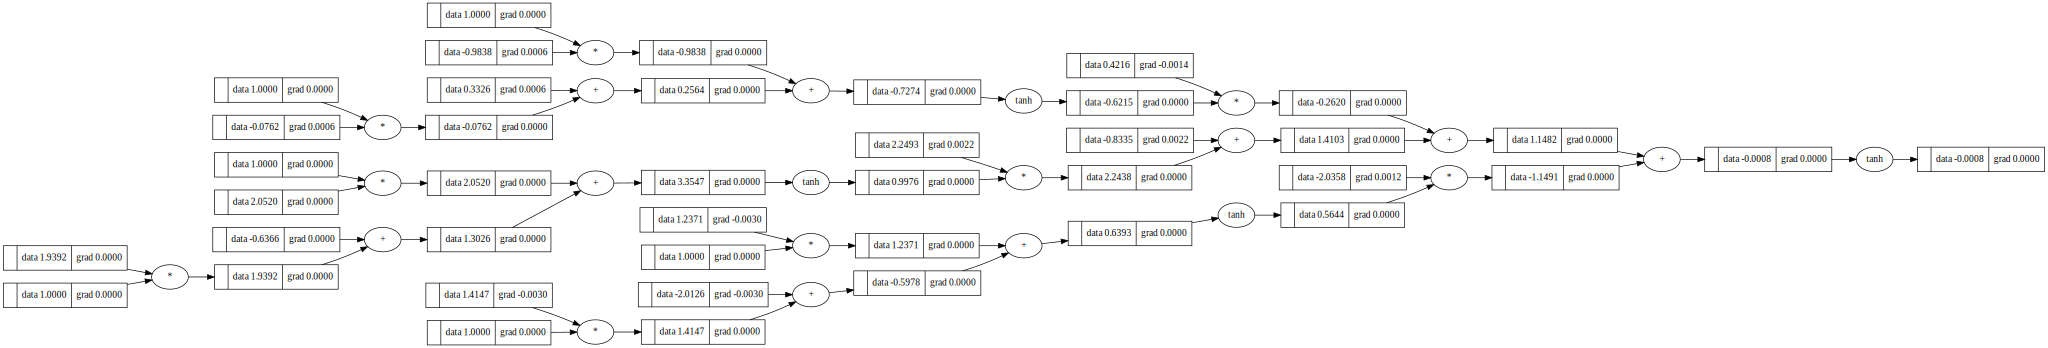

In [9]:
draw_dot(out)